The code is developed for the paper "Double Customer Segmentation Applied On RFM-VD And New Customer Transition Score (CTS)"

# Loading Data and Preprocessing

In [85]:
%%capture
%run "rfmvd.ipynb"

In [86]:
rfmvd_scaled = rfmvd_scaled # type: ignore

# Imports

In [87]:
import numpy as np
import matplotlib.pyplot as plt
# ML
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import DBSCAN
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
import time
import warnings
warnings.filterwarnings("ignore")

# Segmentation Algorithms

## K-means

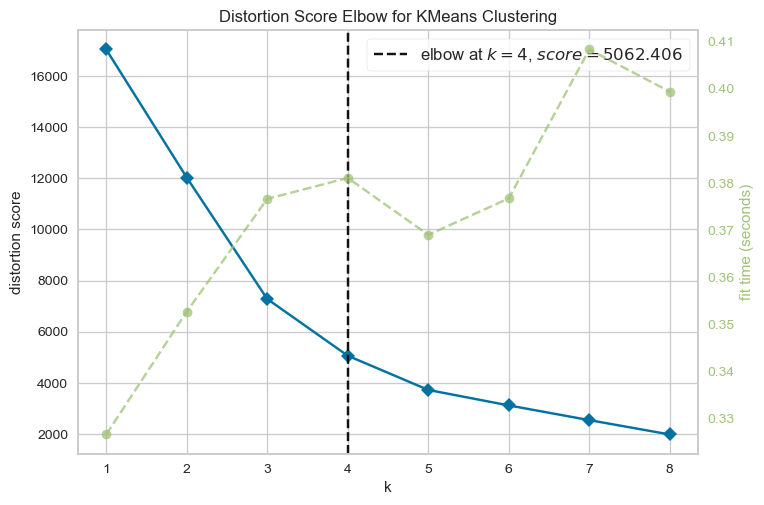

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [88]:
# RFM
vars = ['Recency', 'Frequency', 'Monetary']
rfm = rfmvd_scaled[vars]
model = KMeans()
visualizer = KElbowVisualizer(model, k=(1,9))

visualizer.fit(rfm)
visualizer.show()

In [89]:
n = 4 # number of clusters

In [90]:
st = time.time()
kmeans = KMeans(n_clusters=n, max_iter=1000, random_state=1)
kmeans.fit(rfm)
et = time.time()
kmeans_t = round((et - st) * 1000, 2)
print(f"> Time: {kmeans_t} ms")

> Time: 370.49 ms


In [91]:
cluster_labels = kmeans.labels_
rfm['Labels'] = cluster_labels

print(f"For n = {n}:")
kmeans_s = silhouette_score(rfm, cluster_labels)
print(f"> Silhouette score: {kmeans_s}")

For n = 4:
> Silhouette score: 0.6540730456740649


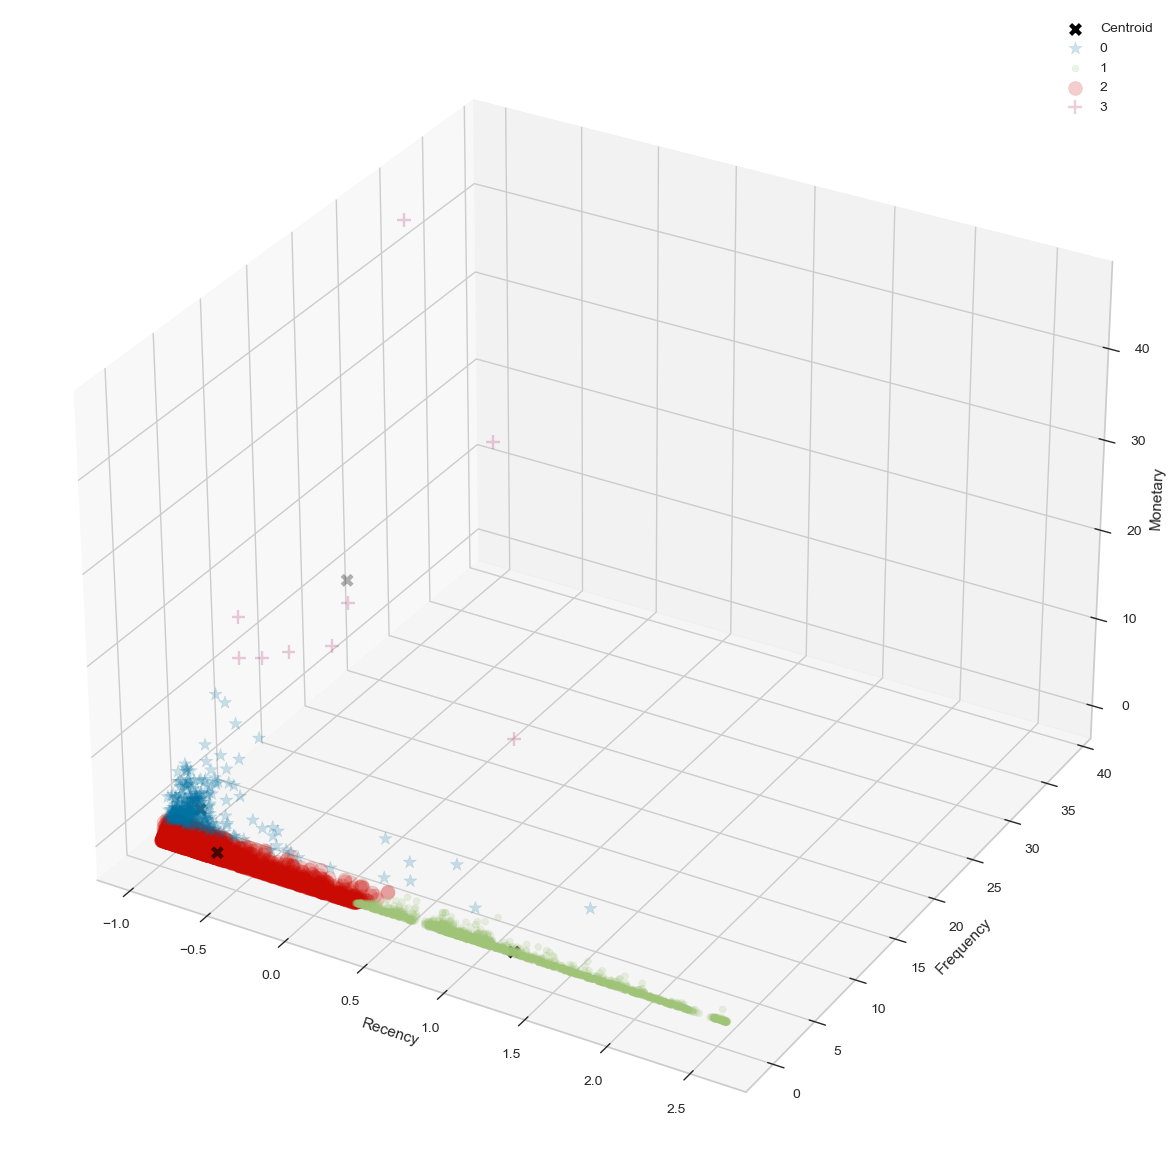

In [92]:
# RFM clustering graph
centroids = kmeans.cluster_centers_
u_labels = np.unique(cluster_labels)
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111, projection='3d')
# ax = plt.axes(projection='3d')
ax.set_xlabel("Recency")
ax.set_ylabel("Frequency")
ax.set_zlabel("Monetary")
colors = []
markers = ['*', '.', 'o', '+']

# plotting centroids
ax.scatter(centroids[:,0] , centroids[:,1] , centroids[:,2], marker='x', 
                s=5, linewidths=10, c='black', label='Centroid', zorder=2)
#plotting the results:
for i in u_labels:
    ax.scatter(rfm[rfm.Labels == i]['Recency'] , rfm[rfm.Labels == i]['Frequency'] , rfm[rfm.Labels == i]['Monetary'], label = i, zorder=1, marker=markers[i], s=100, alpha=0.2)

ax.legend()
plt.show()

In [93]:
centroids

array([[-0.83057114,  1.81727117,  1.96530786],
       [ 1.27527923, -0.26333615, -0.284907  ],
       [-0.61153739, -0.06939875, -0.06602898],
       [-0.75159855, 17.30980617, 15.26386196]])

## DBSCAN

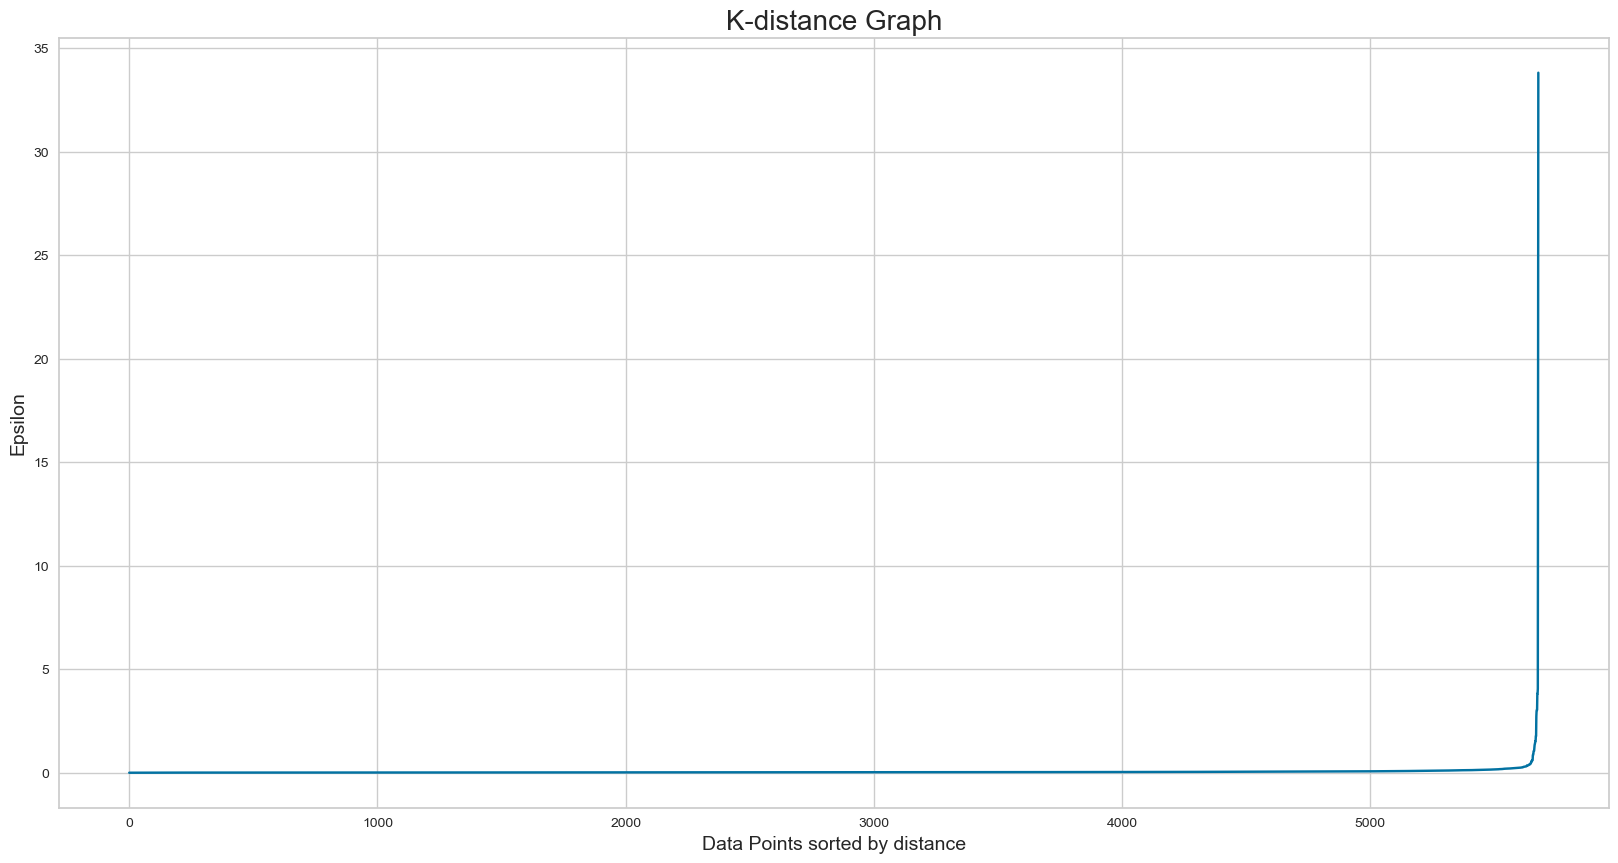

In [94]:
from sklearn.neighbors import NearestNeighbors
neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(rfm)
distances, indices = nbrs.kneighbors(rfm)

# Plotting K-distance Graph
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.figure(figsize=(20,10))
plt.plot(distances)
plt.title('K-distance Graph',fontsize=20)
plt.xlabel('Data Points sorted by distance',fontsize=14)
plt.ylabel('Epsilon',fontsize=14)
plt.show()

In [95]:
e = 0.4
s = 6

In [96]:
st = time.time()
dbscan = DBSCAN(eps=e, min_samples=s)
dbscan.fit(rfm)
et = time.time()
dbscan_t = round((et - st) * 1000, 2)
print(f"> Time: {dbscan_t} ms")

> Time: 165.78 ms


In [97]:
cluster_labels = dbscan.labels_
rfm['Labels'] = cluster_labels

print(f"For e={e}, s={s}:")
dbscan_s = silhouette_score(rfm, cluster_labels)
print(f"> Silhouette score: {dbscan_s}")


For e=0.4, s=6:
> Silhouette score: 0.6313477857498857


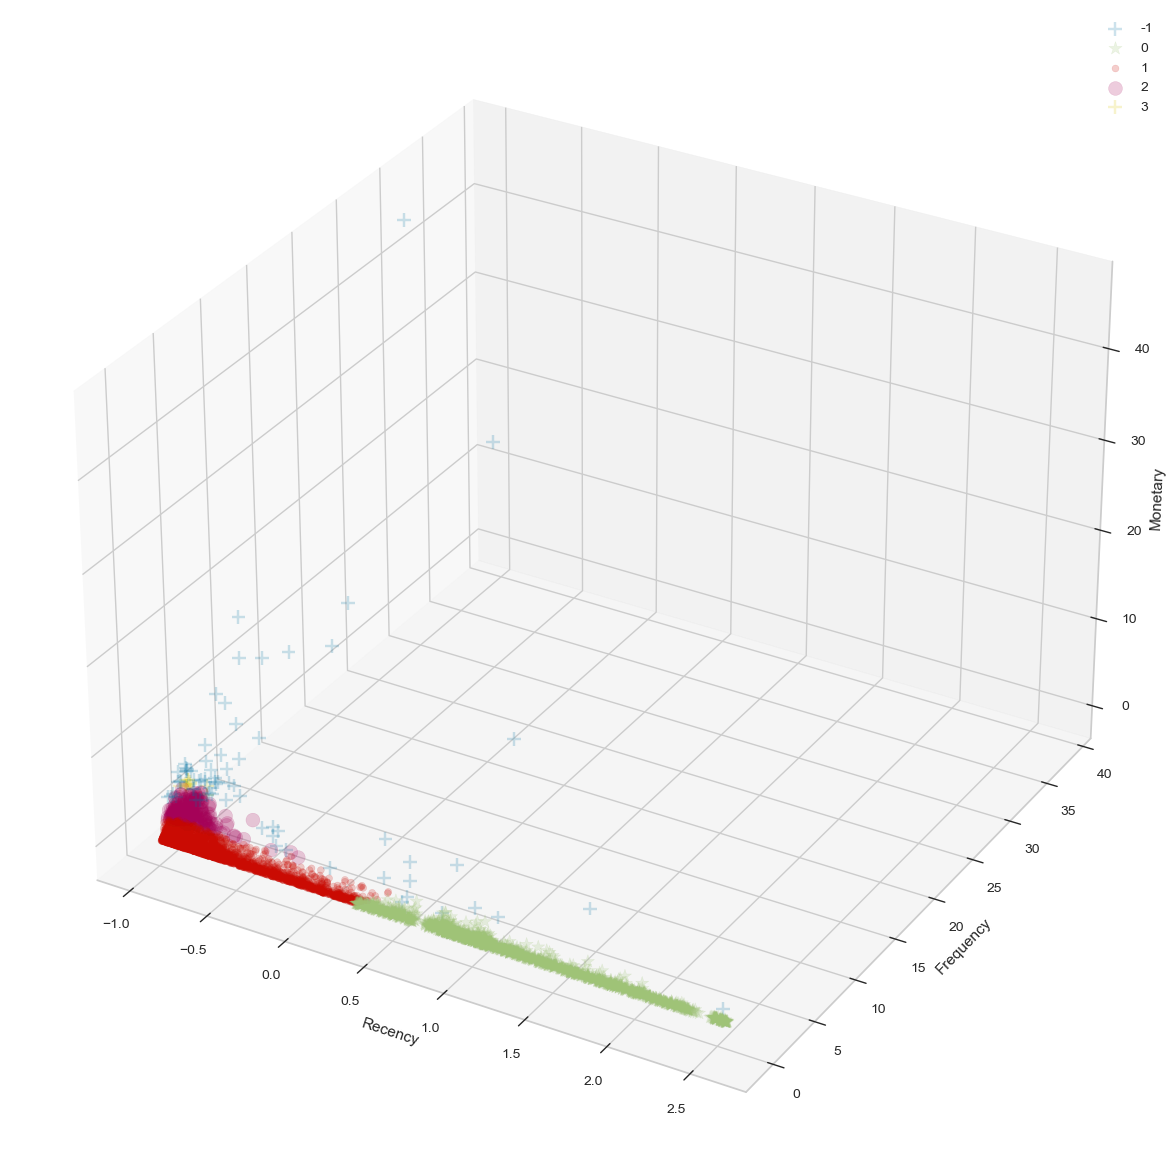

In [98]:
u_labels = np.unique(cluster_labels[1:])
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111, projection='3d')
# ax = plt.axes(projection='3d')
ax.set_xlabel("Recency")
ax.set_ylabel("Frequency")
ax.set_zlabel("Monetary")
colors = []
markers = ['*', '.', 'o', '+']

#plotting the results:
for i in u_labels:
    ax.scatter(rfm[rfm.Labels == i]['Recency'] , rfm[rfm.Labels == i]['Frequency'] , rfm[rfm.Labels == i]['Monetary'], label = i, zorder=1, marker=markers[i], s=100, alpha=0.2)

ax.legend()
plt.show()

# Heirarchical clustring

In [99]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)


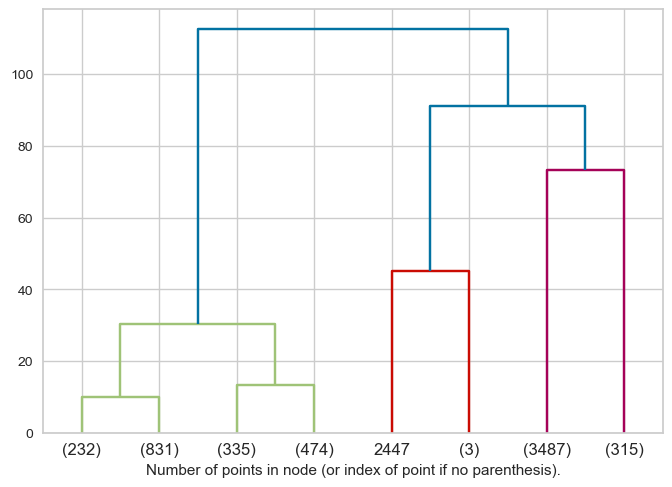

In [100]:
n = 4
agl = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
agl.fit(rfm)
plot_dendrogram(agl, truncate_mode="level", p=2)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

In [101]:
st = time.time()
agl = AgglomerativeClustering(n_clusters=n)
agl.fit(rfm)
et = time.time()
agl_t = round((et - st) * 1000, 2)
print(f"> Time: {agl_t} ms")

> Time: 519.7 ms


In [102]:
cluster_labels = agl.labels_
rfm['Labels'] = cluster_labels

print(f"For n = {n}:")
agl_s = silhouette_score(rfm, cluster_labels)
print(f"> Silhouette score: {agl_s}")

For n = 4:
> Silhouette score: 0.709086613717535


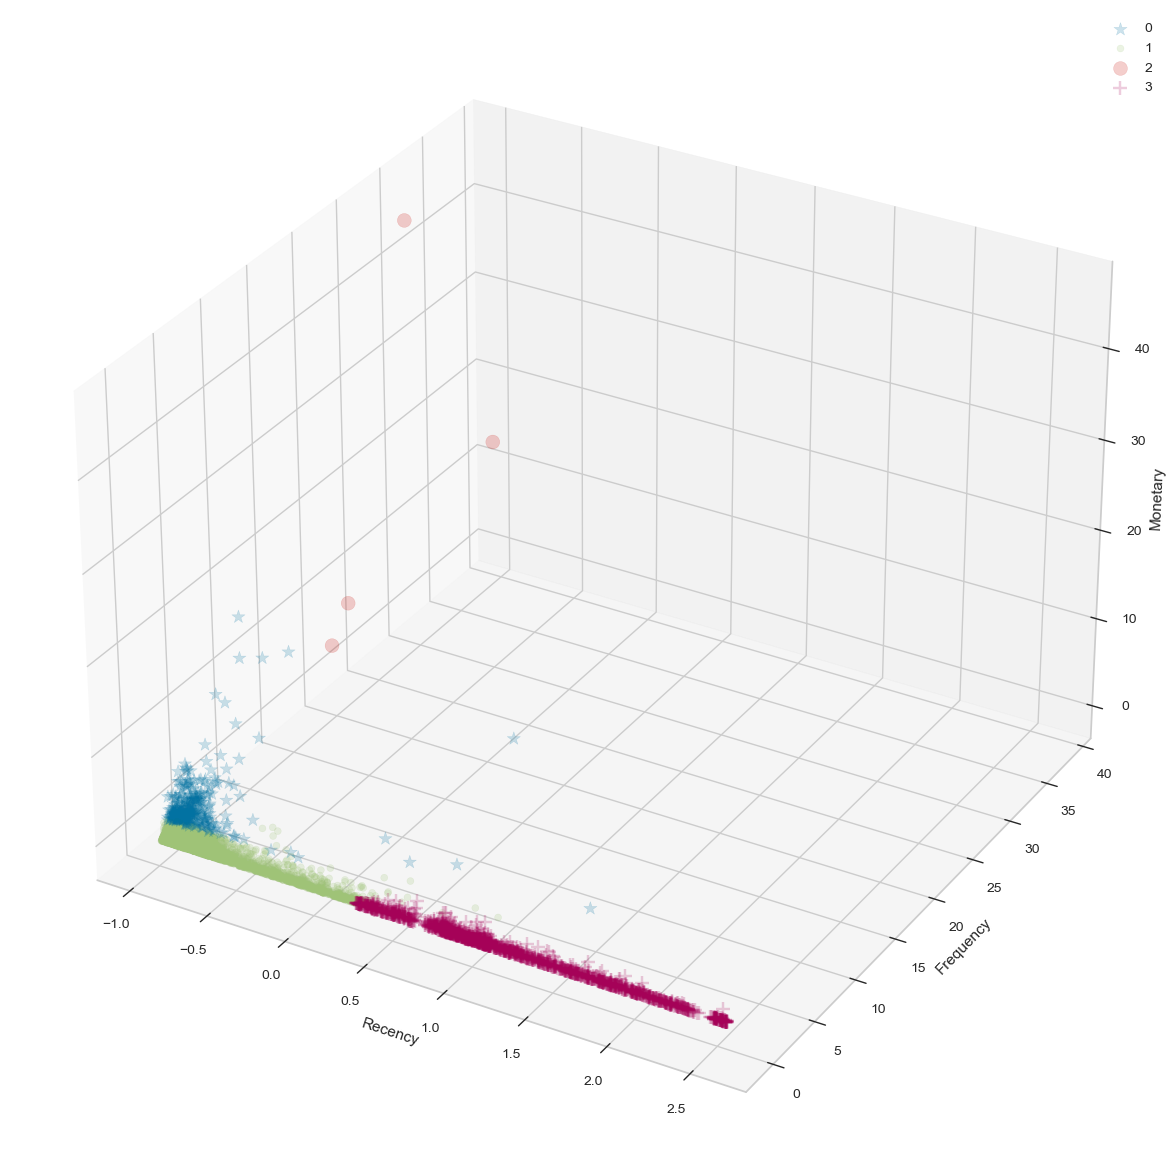

In [103]:
u_labels = np.unique(cluster_labels)
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111, projection='3d')
# ax = plt.axes(projection='3d')
ax.set_xlabel("Recency")
ax.set_ylabel("Frequency")
ax.set_zlabel("Monetary")
colors = []
markers = ['*', '.', 'o', '+']

#plotting the results:
for i in u_labels:
    ax.scatter(rfm[rfm.Labels == i]['Recency'] , rfm[rfm.Labels == i]['Frequency'] , rfm[rfm.Labels == i]['Monetary'], label = i, zorder=1, marker=markers[i], s=100, alpha=0.2)

ax.legend()
plt.show()

# Comparision

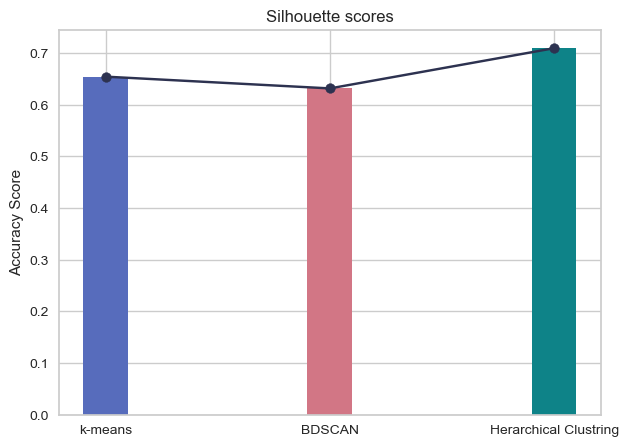

In [104]:
fig, ax = plt.subplots(figsize = (7, 5))

algorithms = ['k-means', 'BDSCAN', 'Herarchical Clustring']
Silhouette_scores = [kmeans_s, dbscan_s, agl_s]

plt.bar(algorithms, Silhouette_scores, color =['#576CBC', '#D27685', '#0E8388'], 
        width = 0.2)
plt.scatter(algorithms, Silhouette_scores, color='#2D3250')
plt.plot(algorithms, Silhouette_scores, color='#2D3250')

width = 0.25  # the width of the bars
ax.set_ylabel('Accuracy Score')
ax.set_title('Silhouette scores')
plt.show()

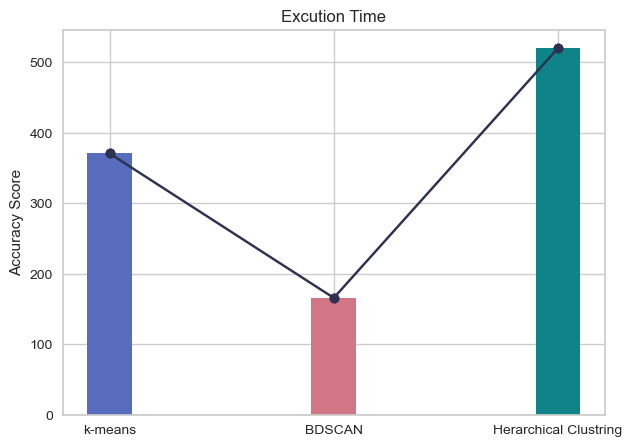

In [105]:
fig, ax = plt.subplots(figsize = (7, 5))

algorithms = ['k-means', 'BDSCAN', 'Herarchical Clustring']
times = [kmeans_t, dbscan_t, agl_t]
# Maybe neet to be sacled.
plt.bar(algorithms, times, color =['#576CBC', '#D27685', '#0E8388'], 
        width = 0.2)
plt.scatter(algorithms, times, color='#2D3250')
plt.plot(algorithms, times, color='#2D3250')

ax.set_ylabel('Accuracy Score')
ax.set_title('Excution Time')
plt.show()